Group 2 Members: Marcos Conde, Jose Manuel Lopez Camuñas, Alex Martin Martinez

In [1]:
!pip install tqdm

In [2]:
import cv2
import numpy as np
import pickle
import os
import warnings
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

num_cores = multiprocessing.cpu_count()

warnings.filterwarnings('ignore')

Let us first read the train and test files

In [3]:
train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]

train_labels = pickle.load(open('train_labels.dat','rb'))
test_labels = pickle.load(open('test_labels.dat','rb'))

# Bag of words with Dense SIFT

First it will be tested the optimal scale to be used with the dense SIFT. The number of keypoints used will be 5000 and we will reduce cardinality with lda as in the previous week we found that the best results were achieved when this number of keypoints were used. 

In [4]:
def evaluate_lda(visual_words_train, visual_words_test,n_components=7,n_neighbors=5,metric='euclidean', cross_val = True):
    # Regular Implementation
    if not cross_val:
        # Reduce Data Cardinality
        lda = LinearDiscriminantAnalysis(n_components=n_components)
        VWlda = lda.fit_transform(visual_words_train,train_labels)
        # KNN with reduced Data
        knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
        knnlda.fit(VWlda, train_labels) 
        # Reduce test
        vwtestlda = lda.transform(visual_words_test)
        # Evaluate test
        accuracy = 100*knnlda.score(vwtestlda, test_labels)
        return accuracy
    

    # StratifiedKFold Implementation
    kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    accuracy = []
    
    def accuracy_cal(train_index, test_index):
        # K Fold
        X_train, X_test = visual_words_train[train_index], visual_words_train[test_index]
        y_train, y_test = np.array(train_labels)[train_index.astype(int)], np.array(train_labels)[test_index.astype(int)]   
        X_test, y_test = np.concatenate((X_test,visual_words_test)), np.concatenate((y_test,test_labels))

        # Reduce Data Cardinality
        lda = LinearDiscriminantAnalysis(n_components=n_components)
        VWlda = lda.fit_transform(X_train ,y_train)
        # KNN with reduced Data
        knnlda = KNeighborsClassifier(n_neighbors=n_neighbors,n_jobs=-1,metric=metric)
        knnlda.fit(VWlda, y_train)
        # Reduce test
        vwtestlda = lda.transform(X_test)
        # Evaluate test
        accuracy.append(100*knnlda.score(vwtestlda, y_test))
        
    
    # Multithread Approach
    Parallel(n_jobs=num_cores,backend='threading')(delayed(accuracy_cal)(train_index, test_index)for train_index, test_index in tqdm(kf.split(visual_words_train, train_labels),position=0, leave=True))
        
        
    # Final Score
    return sum(accuracy)/len(accuracy)

 Then we turn those descriptors into visual words

In [5]:
k = 128
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)

def get_visual_words(descriptors,descriptors_np,codebook,k,test=False):
    # Fit codebook for training
    if not test:
        codebook.fit(descriptors_np)
        
    visual_words = np.zeros((len(descriptors), k), dtype=np.float32)
    def get_words_and_visual(i):
        
        words = codebook.predict(descriptors[i])
        visual_words[i,:] = np.bincount(words, minlength=k)
        return words
    
    # Get words/visual words
    words = Parallel(n_jobs=num_cores,backend='threading')(delayed(get_words_and_visual)(i) for i in tqdm(range(len(descriptors)),total=len(descriptors), position=0, leave=True))
        
    
    return words, visual_words

In [6]:
def get_dense_SIFT_features(images, lbls, nfeatures=5000,scaling=1):
    descriptors = []
    label_per_descriptor = []
    descriptors_np = None

    # SIFT extractor
    sift = cv2.SIFT_create(nfeatures=nfeatures)
    
    def descriptors_and_labels(filename, label):
        # Read image, cast to gray and resize by scaling
        ima = cv2.imread(filename)
        gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, (gray.shape[0]//scaling,gray.shape[1]//scaling), interpolation = cv2.INTER_AREA)

        # Extract Keypoints and compute descriptors
        step_size = 5
        kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                        for x in range(0, gray.shape[1], step_size)]

        kp, des = sift.compute(gray, kp)

        # Save descriptor and labels
        descriptors.append(des)
        label_per_descriptor.append(label)
        
        
    
    Parallel(n_jobs=num_cores,backend='threading')(delayed(descriptors_and_labels)(filename,label)for filename, label in tqdm(zip(images,lbls),total = len(images), position=0, leave=True))
        
    
    descriptors_np = np.vstack(descriptors)

    
    return descriptors_np, descriptors, label_per_descriptor

### Plotting Some Data

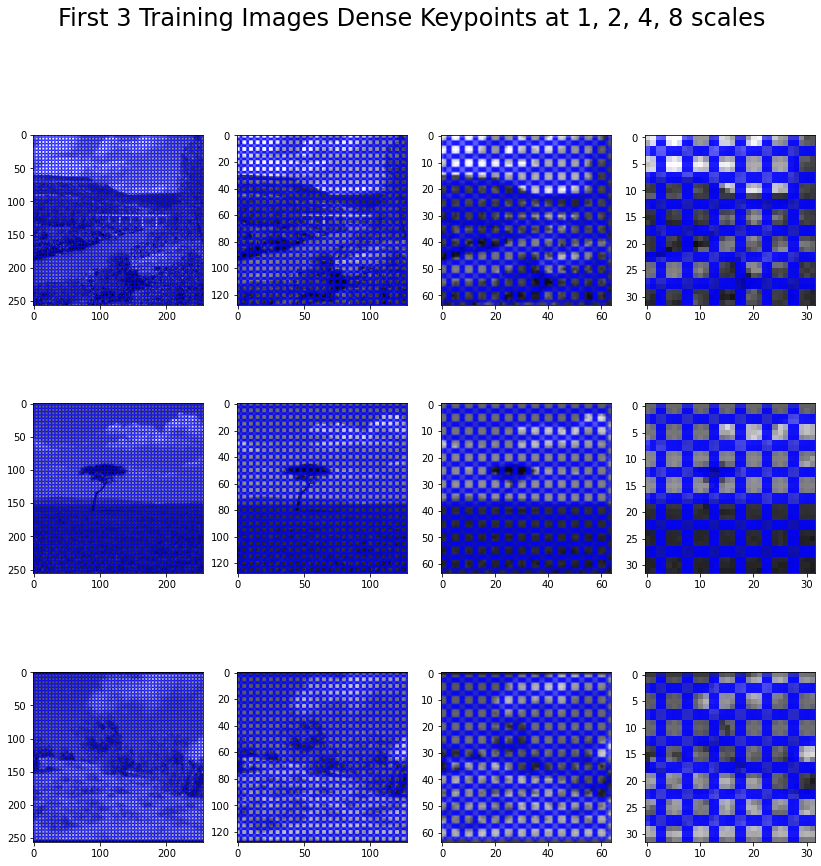

In [7]:

import matplotlib.pyplot as plt

def get_image_kp(filename,scaling):
    # Read image, cast to gray and resize by scaling
    ima = cv2.imread(filename)
    gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (gray.shape[0]//scaling,gray.shape[1]//scaling), interpolation = cv2.INTER_AREA)

    # Extract Keypoints and draw them on the image
    step_size = 5
    kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                    for x in range(0, gray.shape[1], step_size)]
    im_with_keypoints = cv2.drawKeypoints(gray,kp,np.array([]),(0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return im_with_keypoints



fig = plt.figure(figsize=(14, 14))
columns = 4
rows = 3

# Plot first 3 training images with keypoints on at different scales 
for idx, filename in enumerate(train_images_filenames[:3]):
    im1 = get_image_kp(filename, 1)
    fig.add_subplot(rows, columns, 1 + idx*columns)
    plt.imshow(im1)

    im2 = get_image_kp(filename, 2)
    fig.add_subplot(rows, columns, 2 + idx*columns)
    plt.imshow(im2)

    im4 = get_image_kp(filename, 4)
    fig.add_subplot(rows, columns, 3 + idx*columns)
    plt.imshow(im4)

    im8 = get_image_kp(filename, 8)
    fig.add_subplot(rows, columns, 4 + idx*columns)
    plt.imshow(im8)

fig.suptitle('First 3 Training Images Dense Keypoints at 1, 2, 4, 8 scales', fontsize=24)
plt.show()

# Evaluating Dense SIFT at different scales

In [8]:
def evaluate_dense_SIFT(nfeatures=5000,scaling=1, k=128):
    print("Evaluating Dense SIFT with {} features and scaling {}".format(nfeatures,scaling))
    print(50*"-")

    # Path to store precalculated data
    if not os.path.exists("./stored_results"):
        os.mkdir("./stored_results")
    
    # File to save/search
    f = "dense_vw_train_scale-{}_nfeatures-{}_k-{}.pkl".format(scaling,nfeatures,k)

    # If its not already saved we compute
    if f not in os.listdir("./stored_results"):
        # Get Dense SIFT Descriptors
        train_descriptors_np, train_descriptors, train_label_per_descriptor = get_dense_SIFT_features(train_images_filenames, train_labels, nfeatures,scaling)
        test_descriptors_np, test_descriptors, test_label_per_descriptor = get_dense_SIFT_features(test_images_filenames, test_labels, nfeatures,scaling)

        # Compute Visual Words
        words_train, visual_words_train = get_visual_words(train_descriptors,train_descriptors_np,codebook,k)
        words_test, visual_words_test = get_visual_words(test_descriptors,test_descriptors_np,codebook,k,test=True)

        # Save Visual Words
        pickle.dump(visual_words_train, open("./stored_results/"+f, 'wb'))
        pickle.dump(visual_words_test, open("./stored_results/"+f.replace("train", "test"), 'wb'))

    # We load precalculated data
    else:
        visual_words_train = pickle.load(open("./stored_results/"+f,'rb'))
        visual_words_test = pickle.load(open("./stored_results/"+f.replace("train", "test"),'rb'))

    # Evaluate with CV
    lda_acc = evaluate_lda(visual_words_train, visual_words_test, n_components=7,n_neighbors=5,metric='euclidean')
    return [lda_acc]

In [9]:
scales = [1,2,4,8]

results = {}

for n in scales: 
    results[str(n)+" scaling"] = evaluate_dense_SIFT(nfeatures=5000,scaling=n)

5it [00:00, 1529.87it/s]

Evaluating Dense SIFT with 5000 features and scaling 1
--------------------------------------------------



5it [00:00, 4308.92it/s]

Evaluating Dense SIFT with 5000 features and scaling 2
--------------------------------------------------



5it [00:00, 3701.95it/s]

Evaluating Dense SIFT with 5000 features and scaling 4
--------------------------------------------------



5it [00:00, 4241.81it/s]

Evaluating Dense SIFT with 5000 features and scaling 8
--------------------------------------------------


#### DataFrame format (Numerical Representation)

In [10]:
df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ["KNN-LDA"]
df

,KNN-LDA
1 scaling,78.008870
2 scaling,71.467367
4 scaling,61.088635
8 scaling,46.196826


#### Ploting Results

We can observe that as the images get smaller the accuracy of the method also decreases. It may be caused by the fact that the images loses resolutions and therefore information.

<AxesSubplot:>

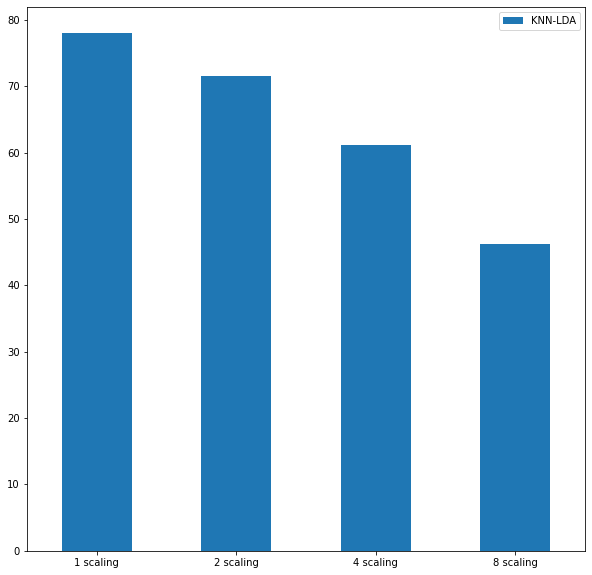

In [11]:
df.plot(kind="bar",figsize=(10,10), rot=0)

# Evaluating Dense SIFT at different scales and number of keypoints
We will also look if varying the number of features in the downsacaled images can produce better results. We will test it with images being reduced 4 times it's original size

In [12]:
opt = [100,1000,5000, 10000,50000]

results = {}

for n in opt:   
    results[str(n)+" features"] = evaluate_dense_SIFT(nfeatures=n,scaling=4)

5it [00:00, 3559.93it/s]

Evaluating Dense SIFT with 100 features and scaling 4
--------------------------------------------------



5it [00:00, 4770.59it/s]

Evaluating Dense SIFT with 1000 features and scaling 4
--------------------------------------------------



5it [00:00, 4100.00it/s]

Evaluating Dense SIFT with 5000 features and scaling 4
--------------------------------------------------



5it [00:00, 4086.42it/s]

Evaluating Dense SIFT with 10000 features and scaling 4
--------------------------------------------------



5it [00:00, 4902.18it/s]

Evaluating Dense SIFT with 50000 features and scaling 4
--------------------------------------------------


#### DataFrame format (Numerical Representation)

In [13]:
df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ["KNN-LDA"]
df

,KNN-LDA
100 features,59.448993
1000 features,59.347527
5000 features,61.088635
10000 features,59.922237
50000 features,60.294045


#### Ploting Results

The number of features used when the image has been downscaled seems to have small(close to no effect) in the performance once the image has been downscaled. (Probably because of the DENSE SIFT)

<AxesSubplot:>

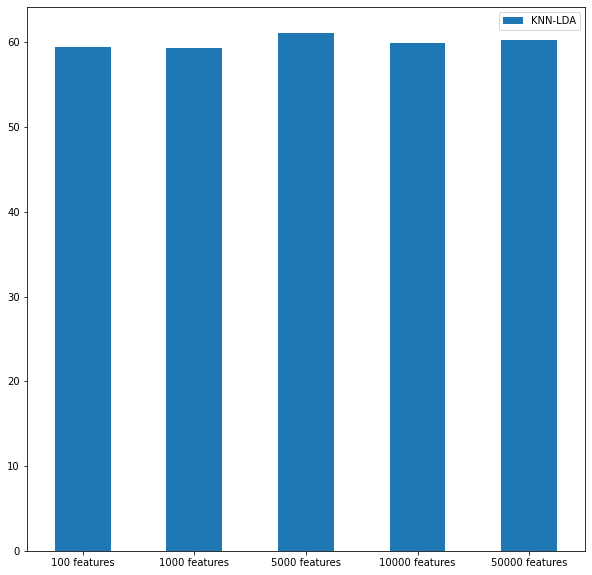

In [14]:
df.plot(kind="bar",figsize=(10,10), rot=0)

# Testing different codebook k sizes for the dense SIFT

Using the previous scaling found to be the best one we will also test the best k for the previous seleceted parameters

In [15]:
def evaluate_k_codebook(k_values:list(),nfeatures=5000):
    

    train_descriptors_np, train_descriptors, train_label_per_descriptor = get_dense_SIFT_features(train_images_filenames, train_labels)
    test_descriptors_np, test_descriptors, test_label_per_descriptor = get_dense_SIFT_features(test_images_filenames, test_labels)
    
    results = {}
    
    for k in k_values:
        print("Evaluating SIFT with {} features and k={}".format(nfeatures,k))
        print(50*"-")
        f = "dense_vw_train_scale-{}_nfeatures-{}_k-{}.pkl".format(1,nfeatures,k)
        if f not in os.listdir("./stored_results"):
            # Compute Visual Words
            codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
            words_train, visual_words_train = get_visual_words(train_descriptors,train_descriptors_np,codebook,k)
            words_test, visual_words_test = get_visual_words(test_descriptors,test_descriptors_np,codebook,k,test=True)
            # Save Visual Words
            pickle.dump(visual_words_train, open("./stored_results/"+f, 'wb'))
            pickle.dump(visual_words_test, open("./stored_results/"+f.replace("train", "test"), 'wb'))

    
        else:
            # Load Precalculated Visual Words
            visual_words_train = pickle.load(open("./stored_results/"+f,'rb'))
            visual_words_test = pickle.load(open("./stored_results/"+f.replace("train", "test"),'rb'))

        results["k = "+str(k)]= evaluate_lda(visual_words_train, visual_words_test, n_components=7,n_neighbors=5,metric='euclidean')
        
    return results
    


opt = [32, 64, 128, 256, 512, 1024]

results = evaluate_k_codebook(nfeatures=2500, k_values=opt)

100%|██████████| 807/807 [00:12<00:00, 65.24it/s]
5it [00:00, 1503.23it/s]

Evaluating SIFT with 2500 features and k=32
--------------------------------------------------



5it [00:00, 3063.32it/s]

Evaluating SIFT with 2500 features and k=64
--------------------------------------------------



5it [00:00, 4571.95it/s]

Evaluating SIFT with 2500 features and k=128
--------------------------------------------------



5it [00:00, 4330.27it/s]

Evaluating SIFT with 2500 features and k=256
--------------------------------------------------



5it [00:00, 4197.66it/s]

Evaluating SIFT with 2500 features and k=512
--------------------------------------------------



5it [00:00, 4210.30it/s]

Evaluating SIFT with 2500 features and k=1024
--------------------------------------------------


#### DataFrame format (Numerical Representation)

In [16]:
df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ["KNN-LDA"]
df

,KNN-LDA
k = 32,69.421920
k = 64,73.242001
k = 128,76.318467
k = 256,78.059531
k = 512,76.960916
k = 1024,66.244288


#### Ploting Results
When varying the codebook sizes the number of bins used to produce the histograms changes. In this test we observe that for the three methods when 256 was used as the codebook size the results were better (We also observe that when k is between 128 and 512, the results were similar.)

<AxesSubplot:>

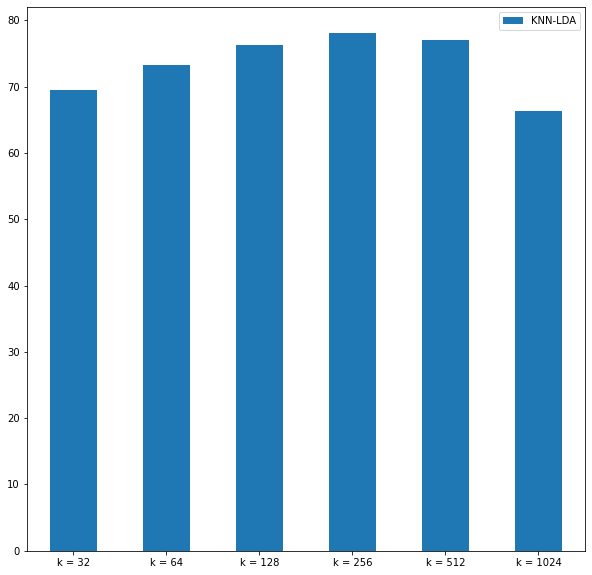

In [17]:
df.plot(kind="bar",figsize=(10,10), rot=0)

# Normalizing the data

Here it will be tested different data normalization methods to look if it can improve the performance of the previous methods: L1, L2, MinMax and Standardarisation.

In [18]:
def evaluate_dense_SIFT_normalization(nfeatures=5000,scaling=1, k=256,norm='l1'):
    print("Evaluating Dense SIFT with {} features, scaling {} and {} normalization.".format(nfeatures,scaling,norm))
    print(50*"-")

    f = "dense_vw_train_scale-{}_nfeatures-{}_k-{}_norm-{}.pkl".format(scaling,nfeatures,k,norm)

    if f not in os.listdir("./stored_results"):

        # Calculate Descriptor
        train_descriptors_np, train_descriptors, train_label_per_descriptor = get_dense_SIFT_features(train_images_filenames, train_labels, nfeatures,scaling)
        test_descriptors_np, test_descriptors, test_label_per_descriptor = get_dense_SIFT_features(test_images_filenames, test_labels, nfeatures,scaling)
        
        # Choose Normalizer
        if norm != 'std':
            normalizer = Normalizer(norm=norm)
        else:   
            normalizer = StandardScaler()

        # Train Normalization
        train_descriptors_np = normalizer.fit_transform(train_descriptors_np)
        test_descriptors_np = normalizer.transform(test_descriptors_np)
        # Flatten from 3d to 2d
        train_descriptors_2d = np.array(train_descriptors)
        train_descriptors_2d = train_descriptors_2d.reshape(-1, train_descriptors_2d.shape[-1])
        # Apply Normalization
        train_descriptors_2d = normalizer.fit_transform(train_descriptors_2d)
        # Back to original 3D
        train_descriptors = train_descriptors_2d.reshape(np.array(train_descriptors).shape)

        # Test Normalization
        # Flatten from 3d to 2d
        test_descriptors_2d = np.array(test_descriptors)
        test_descriptors_2d = test_descriptors_2d.reshape(-1, test_descriptors_2d.shape[-1])
        # Apply Normalization
        test_descriptors_2d = normalizer.transform(test_descriptors_2d)
        # Back to original 3D
        test_descriptors = test_descriptors_2d.reshape(np.array(test_descriptors).shape)

        # Get Visual Words
        words_train, visual_words_train = get_visual_words(train_descriptors,train_descriptors_np,codebook,k)
        words_test, visual_words_test = get_visual_words(test_descriptors,test_descriptors_np,codebook,k,test=True)

        # Save Visual Words
        pickle.dump(visual_words_train, open("./stored_results/"+f, 'wb'))
        pickle.dump(visual_words_test, open("./stored_results/"+f.replace("train", "test"), 'wb'))
    
    else:
        # Load Visual Words
        visual_words_train = pickle.load(open("./stored_results/"+f,'rb'))
        visual_words_test = pickle.load(open("./stored_results/"+f.replace("train", "test"),'rb'))

    # Evaluate with CV
    lda_acc = evaluate_lda(visual_words_train, visual_words_test, n_components=7,n_neighbors=5,metric='euclidean')
    return [lda_acc]

In [19]:
norms = ['l1','l2', 'max', 'std']

results={}

for norm in norms: 
    results["Normalization used:  "+str(norm)] = evaluate_dense_SIFT_normalization(norm = norm)

5it [00:00, 2931.44it/s]

Evaluating Dense SIFT with 5000 features, scaling 1 and l1 normalization.
--------------------------------------------------



5it [00:00, 4138.84it/s]

Evaluating Dense SIFT with 5000 features, scaling 1 and l2 normalization.
--------------------------------------------------



5it [00:00, 4071.35it/s]

Evaluating Dense SIFT with 5000 features, scaling 1 and max normalization.
--------------------------------------------------



5it [00:00, 3836.02it/s]

Evaluating Dense SIFT with 5000 features, scaling 1 and std normalization.
--------------------------------------------------


#### DataFrame format (Numerical Representation)

In [20]:
df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ["KNN-LDA"]
df

,KNN-LDA
Normalization used: l1,74.729601
Normalization used: l2,78.211501
Normalization used: max,78.008756
Normalization used: std,80.206158


#### Ploting Results
When normalizing the descriptors we can observe the same or little bit of enhancment in the performance. For the L1 the performance was worst and in the other hand the standarization produced better results but in general the normalization of the data doesn't have a lot of impact in the performance for the used data.

<AxesSubplot:>

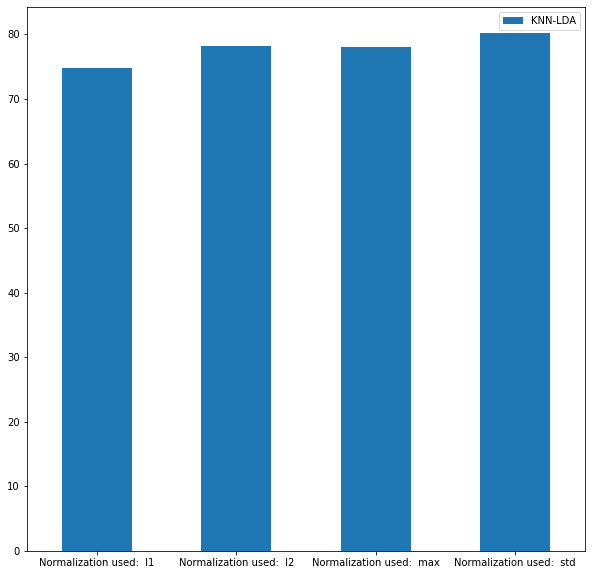

In [21]:
df.plot(kind="bar",figsize=(10,10), rot=0)

# Dense SIFT with SVM

We are going to improve our model from a KNN to a SVM Classifer. We are going to use the normalized (standarisation) data and try different kernels. Also best hyperparameters are selected by a GridSearch

In [22]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV

def evaluate_svm(estimator=LinearSVC(), params = {}, cv = 5):

    # Load Standarized data
    visual_words_train = pickle.load(open("./stored_results/dense_vw_train_scale-1_nfeatures-5000_k-256_norm-std.pkl",'rb'))
    visual_words_test = pickle.load(open("./stored_results/dense_vw_test_scale-1_nfeatures-5000_k-256_norm-std.pkl",'rb'))

    # Reducing Data Cardinality
    lda = LinearDiscriminantAnalysis(n_components=7)
    X_train = lda.fit_transform(visual_words_train,train_labels)
    X_test = lda.transform(visual_words_test)

    # Selecting best model params through GridSearchCV
    model = GridSearchCV(estimator = estimator,n_jobs = -1, param_grid = params, cv = 5)
    model.fit(X_train, train_labels)
    print(model.best_params_)

    # Evaluate model on test set
    score = model.score(X_test, test_labels)

    return score

In [23]:
# Custom Histogram Intersection Kernel for SVC
def histogram_intersection(X,Y):
    kernel = np.zeros((X.shape[0], Y.shape[0]))

    for d in range(X.shape[1]):
        column_1 = X[:, d].reshape(-1, 1)
        column_2 = Y[:, d].reshape(-1, 1)
        kernel += np.minimum(column_1, column_2.T)

    return kernel

In [24]:
opts = [
    # Linear
    ({"estimator": LinearSVC(), "params": { "penalty":["l1", "l2"], "loss": ["hinge", "squared_hinge"], "dual": [False, True], 
    "C": [1, 5, 10, 20, 50], "tol": [1e-1, 1e-2, 1e-3, 1e-4, 1e-5] , "random_state": [42]}}, "Linear"),
    # RBF
    ({"estimator": SVC(), "params": { "kernel":["rbf"], "gamma": [0.1, 1, 10, 100], "C": [1, 5, 10, 20, 50],
     "tol": [1e-1, 1e-2, 1e-3, 1e-4, 1e-5], "random_state": [42]}}, "RBF"),
    # Histogram Intersection
    ({"estimator": SVC(), "params": { "kernel":[histogram_intersection], "gamma": [0.1, 1, 10, 100], "C": [1, 5, 10, 20, 50],
     "tol": [1e-1, 1e-2, 1e-3, 1e-4, 1e-5], "random_state": [42]}}, "Histogram Intersection")
]

results={}

for opt, name in opts:
    results[name] = evaluate_svm(estimator = opt["estimator"], params = opt["params"], cv = 5)*100

{'C': 20, 'dual': True, 'loss': 'hinge', 'penalty': 'l2', 'random_state': 42, 'tol': 0.1}
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf', 'random_state': 42, 'tol': 0.0001}
{'C': 1, 'gamma': 0.1, 'kernel': <function histogram_intersection at 0x7f97fc332af0>, 'random_state': 42, 'tol': 0.01}


#### DataFrame format (Numerical Representation)

In [25]:
df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ["SVC + LDA"]
df

,SVC + LDA
Linear,81.040892
RBF,81.784387
Histogram Intersection,81.660471


#### Ploting Results
It can be observed that for the three kernels tested the performance of the bag of visual words with SVM was overall better. The introduction of the SVM enhances the performance and the difference when using one or another kernel doesn't have a lot of impact in the accuracy. (Notice that the best results were obtained with RBF even though Histogram Intersection is by definition the most suitable kernel).

<AxesSubplot:>

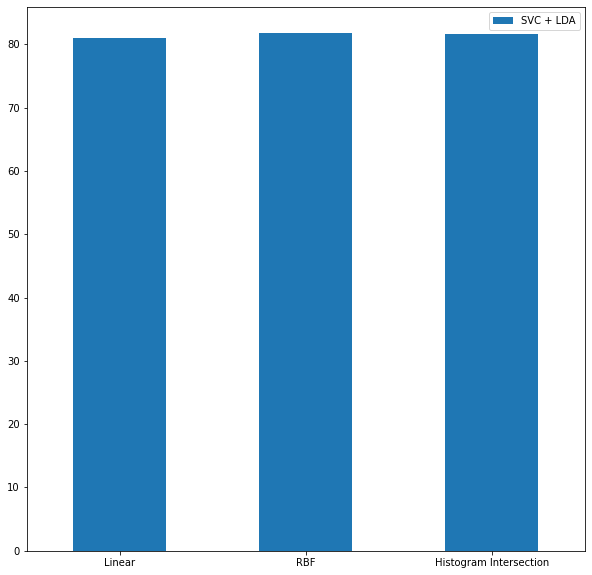

In [26]:
df.plot(kind="bar",figsize=(10,10), rot=0)

# Spatial pyramids

First We Split Image into Blocks

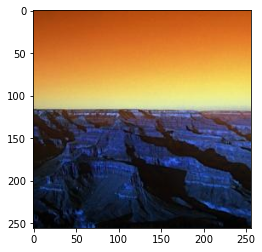

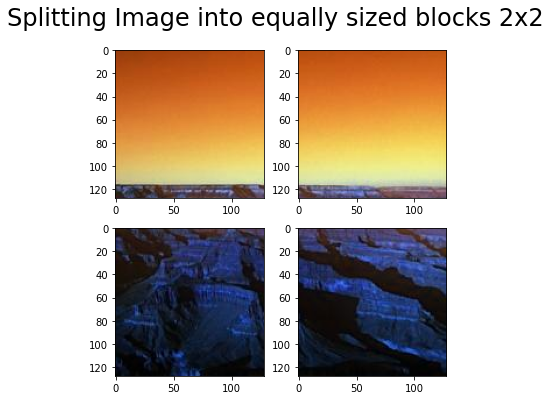

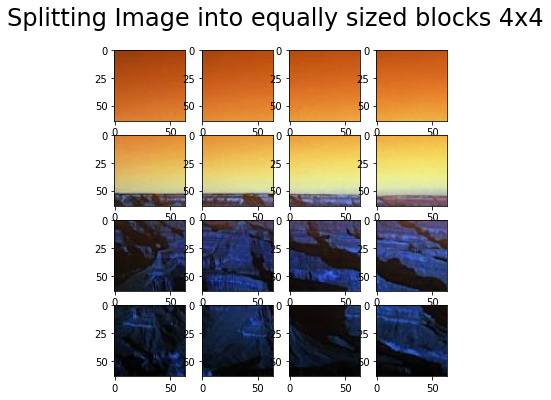

In [27]:
def image_to_windows(image: np.ndarray, n_rows: int, n_cols: int):
    # Estimate block size
    x, y = image.shape[0]/n_rows, image.shape[1]/n_cols
    x, y = int(x), int(y)

    # Split image into blocks
    windows = []
    for i in range(n_rows):
       for j in range(n_cols):
           # Split
           windows.append(image[i*x:(i+1)*x, j*y:(j+1)*y])
    
    return windows

ima = cv2.imread(train_images_filenames[5])
plt.imshow(ima)
plt.show()


fig = plt.figure(figsize=(6, 6))
columns = 2
rows = 2
blocks = image_to_windows(ima, rows, columns)


for idx,im in enumerate(blocks):
    fig.add_subplot(rows, columns, 1 + idx)
    plt.imshow(im)

fig.suptitle('Splitting Image into equally sized blocks 2x2', fontsize=24)
plt.show()

fig = plt.figure(figsize=(6, 6))
columns = 4
rows = 4
blocks = image_to_windows(ima, rows, columns)


for idx,im in enumerate(blocks):
    fig.add_subplot(rows, columns, 1 + idx)
    plt.imshow(im)

fig.suptitle('Splitting Image into equally sized blocks 4x4', fontsize=24)
plt.show()

# Readapt DENSE SIFT FEATURES for pyramid

The main idea was to separate images in blocks and calculate dense SIFT descriptor per block but in the end we could not process full size image because of hardware limitations. Everytime you execute this cell below, kernel dies probably because it runs out of memory. So instead we executed scaling to 1/4 of the original size.

In [65]:
def get_dense_SIFT_features_pyramid(images, lbls, nfeatures=5000,scaling=4, pyramid=2):

    descriptors = []
    label_per_descriptor = []
    descriptors_np = None

    # SIFT extractor
    sift = cv2.SIFT_create(nfeatures=nfeatures)
    
    def descriptors_and_labels(image, label):
        # Read image, cast to gray and resize by scaling
        image = cv2.imread(image)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, (gray.shape[0]//scaling,gray.shape[1]//scaling), interpolation = cv2.INTER_AREA)
        blocks = image_to_windows(gray, pyramid, pyramid)
        block_descriptors = []
        for im in blocks:
        # Extract Keypoints and compute descriptors
            step_size = 5
            kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                            for x in range(0, gray.shape[1], step_size)]

            kp, des = sift.compute(gray, kp)
            block_descriptors.append(des)

        # Save descriptor and labels
        descriptors.append(block_descriptors)
        label_per_descriptor.append(label)
        

    for filename, label in tqdm(zip(images,lbls),total = len(images), position=0, leave=True):
        descriptors_and_labels(filename,label)
    
    descriptors_np = np.vstack(descriptors)


    return descriptors_np, descriptors, label_per_descriptor

In [72]:
def evaluate_dense_SIFT_pyramids(nfeatures=5000,scaling=4, k=256,level=2):
    print("Evaluating Dense SIFT with {} features and scaling {} and pyramid level {}".format(nfeatures,scaling, level))
    print(50*"-")

    if not os.path.exists("./stored_results"):
        os.mkdir("./stored_results")
    
    f = "spatial_pyramids_train-{}_nfeatures-{}_k-{}_levels-{}.pkl".format(scaling,nfeatures,k,level)

    if f not in os.listdir("./stored_results"):
        train_descriptors_np, train_descriptors, train_label_per_descriptor = get_dense_SIFT_features_pyramid(train_images_filenames, train_labels, pyramid = level)
        test_descriptors_np, test_descriptors, test_label_per_descriptor = get_dense_SIFT_features_pyramid(test_images_filenames, test_labels, pyramid = level)

        # Flatten
        train_descriptors_2d = np.array(train_descriptors)
        train_descriptors_2d = train_descriptors_2d.reshape(train_descriptors_2d.shape[0],train_descriptors_2d.shape[1]*train_descriptors_2d.shape[2],train_descriptors_2d.shape[3])
        train_descriptors_np_2d = train_descriptors_np.reshape(-1, train_descriptors_np.shape[-1])
        # Flatten
        test_descriptors_2d = np.array(test_descriptors)
        test_descriptors_2d = test_descriptors_2d.reshape(test_descriptors_2d.shape[0],test_descriptors_2d.shape[1]*test_descriptors_2d.shape[2],test_descriptors_2d.shape[3])
        test_descriptors_np_2d = test_descriptors_np.reshape(-1, test_descriptors_np.shape[-1])

        words_train, visual_words_train = get_visual_words(train_descriptors_2d,train_descriptors_np_2d,codebook,k)
        words_test, visual_words_test = get_visual_words(test_descriptors_2d,test_descriptors_np_2d,codebook,k,test=True)

        pickle.dump(visual_words_train, open("./stored_results/"+f, 'wb'))
        pickle.dump(visual_words_test, open("./stored_results/"+f.replace("train", "test"), 'wb'))

    
    else:
        visual_words_train = pickle.load(open("./stored_results/"+f,'rb'))
        visual_words_test = pickle.load(open("./stored_results/"+f.replace("train", "test"),'rb'))


    lda_acc = evaluate_lda(visual_words_train, visual_words_test, n_components=7,n_neighbors=5,metric='euclidean')
    return [lda_acc]


In [73]:
levels = [1,2,4]

results = {}

for l in levels: 
    results[str(l)+" Spatial Pyramid level(s)"] = evaluate_dense_SIFT_pyramids(nfeatures=5000,scaling=4, k=256, level=l)

  1%|          | 19/1881 [00:00<00:09, 187.02it/s]

Evaluating Dense SIFT with 5000 features and scaling 4 and pyramid level 1
--------------------------------------------------


100%|██████████| 807/807 [00:00<00:00, 962.95it/s] 
5it [00:00, 2079.48it/s]
  1%|          | 15/1881 [00:00<00:12, 146.57it/s]

Evaluating Dense SIFT with 5000 features and scaling 4 and pyramid level 2
--------------------------------------------------


100%|██████████| 807/807 [00:03<00:00, 228.58it/s]
5it [00:00, 1641.99it/s]
  0%|          | 5/1881 [00:00<00:37, 49.56it/s]

Evaluating Dense SIFT with 5000 features and scaling 4 and pyramid level 4
--------------------------------------------------


100%|██████████| 807/807 [01:06<00:00, 12.22it/s]
5it [00:00, 56.87it/s]


#### DataFrame format (Numerical Representation)

In [74]:
df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ["KNN-LDA"]
df

,KNN-LDA
1 Spatial Pyramid level(s),61.578685
2 Spatial Pyramid level(s),60.902424
4 Spatial Pyramid level(s),60.480070


#### Ploting Results
We don't see good results probably because of the scaling. We can observe that 1 level (just all the image) is better than dividing the image in blocks

<AxesSubplot:>

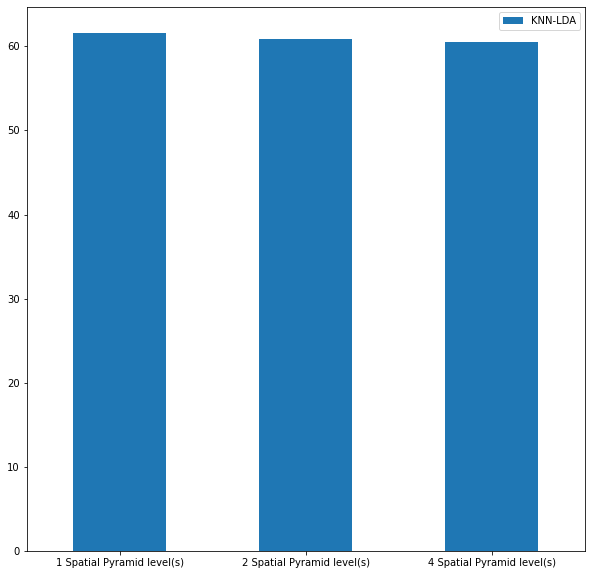

In [75]:
df.plot(kind="bar",figsize=(10,10), rot=0)

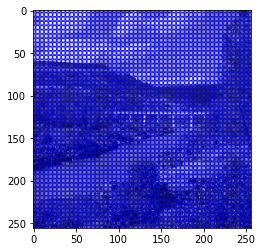

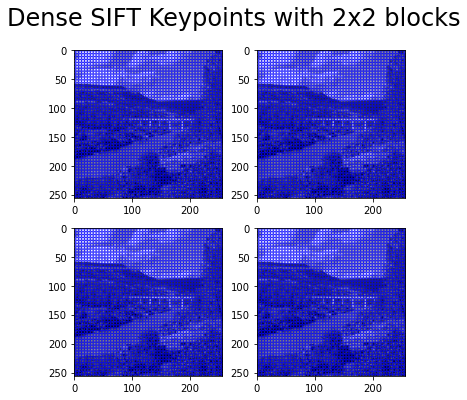

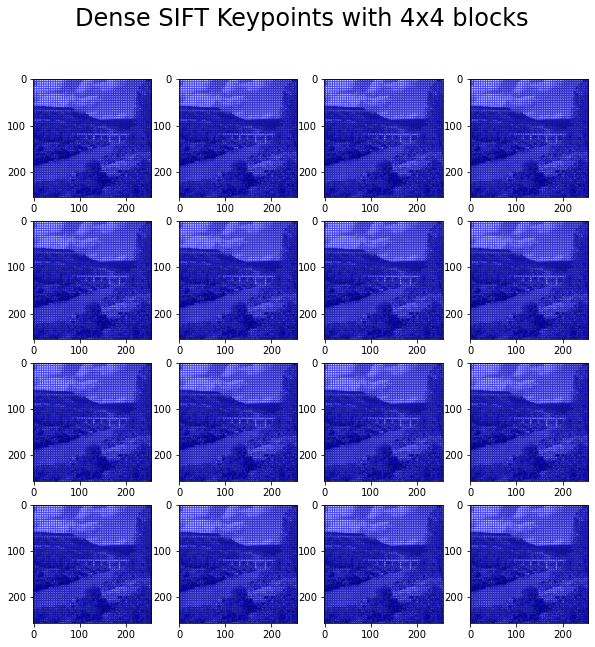

In [78]:

sift = cv2.SIFT_create(nfeatures=5000)

def get_image_kp_blocks(filename,scaling,pyramid=1):
    # Read image, cast to gray and resize by scaling
    ima = cv2.imread(filename)
    gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (gray.shape[0]//scaling,gray.shape[1]//scaling), interpolation = cv2.INTER_AREA)
    blocks = image_to_windows(gray, pyramid, pyramid)
    kps_ims = []
    for im in blocks:
    # Extract Keypoints and compute descriptors
        step_size = 5
        kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                        for x in range(0, gray.shape[1], step_size)]

        kp, des = sift.compute(gray, kp)
        im_with_keypoints = cv2.drawKeypoints(gray,kp,np.array([]),(0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        kps_ims.append(im_with_keypoints)

    return kps_ims



# Plot first 3 training images with keypoints on at different scales 

im1 = get_image_kp_blocks(train_images_filenames[0], 1, 1)
plt.imshow(im1[0])
plt.show()

im2 = get_image_kp_blocks(train_images_filenames[0], 1 , 2)
fig = plt.figure(figsize=(6, 6))
columns = 2
rows = 2


for idx,im in enumerate(im2):
    fig.add_subplot(rows, columns, 1 + idx)
    plt.imshow(im)

fig.suptitle('Dense SIFT Keypoints with 2x2 blocks', fontsize=24)
plt.show()

im4 = get_image_kp_blocks(train_images_filenames[0], 1 , 4)
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 4


for idx,im in enumerate(im4):
    fig.add_subplot(rows, columns, 1 + idx)
    plt.imshow(im)

fig.suptitle('Dense SIFT Keypoints with 4x4 blocks', fontsize=24)
plt.show()